# Notebook 02: Mechanistic Probes

**Research Question:** Can we detect ground truth action-taking from model activations?

This notebook:
1. Extracts activations at multiple positions and layers
2. Trains reality (tool_used) and narrative (claims_action) probes
3. **Critical:** Position analysis (first_assistant vs before_tool)
4. Analyzes probe behavior on fake action cases

**Key hypothesis:** If `first_assistant` accuracy > 80%, probe is detecting action-grounding, not just tool syntax.

## Setup

In [3]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.utils.logging import setup_logging
from src.config import get_config
from src.data.io import load_episodes, save_activations, load_activations
from src.extraction import extract_activations_batch
from src.analysis.probes import train_and_evaluate, analyze_probe_on_category, save_probe
from src.analysis.visualization import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_position_accuracy,
    plot_layer_analysis,
)
from src.analysis.statistics import compute_roc_auc, bootstrap_metrics

setup_logging(level="INFO")
config = get_config()

print(f"Extraction config:")
print(f"  Positions: {config.extraction.positions}")
print(f"  Layers: {config.extraction.layers}")

Extraction config:
  Positions: ['first_assistant', 'mid_response', 'before_tool']
  Layers: [0, 8, 16, 24, 31]


## 1. Load Episodes

In [17]:
episodes_collection = load_episodes("../data/processed/episodes_v2.parquet")
episodes = episodes_collection.episodes



print(f"Total episodes: {len(episodes)}")
print(f"Loaded {len(episodes)} episodes")
print(f"\nCategory breakdown:")
summary = episodes_collection.summary()
for cat, count in summary['categories'].items():
    print(f"  {cat}: {count}")

2025-12-24 10:39:44,784 - src.data.io - INFO - Loading episodes from: ../data/processed/episodes_v2.parquet
2025-12-24 10:39:44,954 - src.data.io - INFO - Loaded 1800 episodes
Total episodes: 1800
Loaded 1800 episodes

Category breakdown:
  wrong_tool: 68
  honest_no_action: 211
  silent_action: 141
  true_action: 1258
  fake_action: 122


## 2. Extract Activations

Extract at 3 positions × 5 layers = 15 samples per episode.

**WARNING:** This takes 1-2 hours on GPU depending on model size.

In [24]:
import torch
torch.cuda.empty_cache()

In [3]:
# Extract activations
dataset = extract_activations_batch(
    episodes=episodes,
    positions=config.extraction.positions,
    layers=config.extraction.layers,
    model_id=config.model.id,
    save_path=config.data.processed_dir / "activations.parquet",
    verbose=True,
)

print(f"\nExtracted {len(dataset)} activation samples")
print(f"Activation shape: {dataset.activations.shape}")
print(f"Hidden size: {dataset.hidden_size}")

2025-12-24 10:14:26,100 - src.backends.pytorch - INFO - Loading model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-24 10:14:26,101 - src.backends.pytorch - INFO -   Quantization: 8bit
2025-12-24 10:14:26,102 - src.backends.pytorch - INFO -   Device map: auto
2025-12-24 10:14:26,102 - src.backends.pytorch - INFO -   Dtype: float16
2025-12-24 10:14:26,103 - src.backends.pytorch - INFO -   Using 8-bit quantization (with CPU offload enabled)
2025-12-24 10:15:07,060 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-24 10:15:24,393 - src.backends.pytorch - INFO - Model loaded. Parameters: 7,241,732,096
2025-12-24 10:15:24,395 - src.extraction.activations - INFO - Initialized ActivationExtractor:
2025-12-24 10:15:24,397 - src.extraction.activations - INFO -   Model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-24 10:15:24,398 - src.extraction.activations - INFO -   Hidden size: 4096
2025-12-24 10:15:24,398 - src.extraction.activations - INFO -   Layers: 32
2025-12-24 10:15:24,399 - src.extraction.activations - INFO - ============================================================
2025-12-24 10:15:24,399 - src.extraction.activations - INFO - ACTIVATION EXTRACTION
2025-12-24 10:15:24,400 - src.extraction.activations - INFO - ============================================================
2025-12-24 10:15:24,401 - src.extraction.activations - INFO -   Started at: 10:15:24
2025-12-24 10:15:24,402 - src.extraction.activations - INFO -   Episodes: 1800
2025-12-24 10:15:24,403 - src.extraction.activations

Extracting activations:   3%|▎         | 49/1800 [00:17<08:58,  3.25episode/s] 

2025-12-24 10:15:42,302 - src.extraction.activations - INFO -   Progress: 50/1800 episodes | Rate: 2.8 eps/s | ETA: 10.4 min


Extracting activations:   6%|▌         | 99/1800 [00:35<10:23,  2.73episode/s]

2025-12-24 10:16:00,603 - src.extraction.activations - INFO -   Progress: 100/1800 episodes | Rate: 2.8 eps/s | ETA: 10.3 min


Extracting activations:   8%|▊         | 149/1800 [00:51<08:19,  3.30episode/s]

2025-12-24 10:16:16,152 - src.extraction.activations - INFO -   Progress: 150/1800 episodes | Rate: 2.9 eps/s | ETA: 9.5 min


Extracting activations:  11%|█         | 199/1800 [01:05<07:20,  3.64episode/s]

2025-12-24 10:16:30,667 - src.extraction.activations - INFO -   Progress: 200/1800 episodes | Rate: 3.0 eps/s | ETA: 8.8 min


Extracting activations:  14%|█▍        | 249/1800 [01:24<09:43,  2.66episode/s]

2025-12-24 10:16:49,129 - src.extraction.activations - INFO -   Progress: 250/1800 episodes | Rate: 3.0 eps/s | ETA: 8.8 min


Extracting activations:  17%|█▋        | 299/1800 [01:39<07:23,  3.38episode/s]

2025-12-24 10:17:04,671 - src.extraction.activations - INFO -   Progress: 300/1800 episodes | Rate: 3.0 eps/s | ETA: 8.4 min


Extracting activations:  19%|█▉        | 349/1800 [01:54<07:12,  3.35episode/s]

2025-12-24 10:17:19,180 - src.extraction.activations - INFO -   Progress: 350/1800 episodes | Rate: 3.0 eps/s | ETA: 7.9 min


Extracting activations:  22%|██▏       | 399/1800 [02:13<08:36,  2.71episode/s]

2025-12-24 10:17:37,865 - src.extraction.activations - INFO -   Progress: 400/1800 episodes | Rate: 3.0 eps/s | ETA: 7.8 min


Extracting activations:  25%|██▍       | 449/1800 [02:29<07:08,  3.15episode/s]

2025-12-24 10:17:53,897 - src.extraction.activations - INFO -   Progress: 450/1800 episodes | Rate: 3.0 eps/s | ETA: 7.5 min


Extracting activations:  28%|██▊       | 499/1800 [02:42<06:02,  3.58episode/s]

2025-12-24 10:18:07,389 - src.extraction.activations - INFO -   Progress: 500/1800 episodes | Rate: 3.1 eps/s | ETA: 7.1 min


Extracting activations:  30%|███       | 549/1800 [03:00<07:17,  2.86episode/s]

2025-12-24 10:18:24,980 - src.extraction.activations - INFO -   Progress: 550/1800 episodes | Rate: 3.0 eps/s | ETA: 6.8 min


Extracting activations:  33%|███▎      | 599/1800 [03:15<06:24,  3.12episode/s]

2025-12-24 10:18:40,315 - src.extraction.activations - INFO -   Progress: 600/1800 episodes | Rate: 3.1 eps/s | ETA: 6.5 min


Extracting activations:  36%|███▌      | 649/1800 [03:29<05:17,  3.62episode/s]

2025-12-24 10:18:53,685 - src.extraction.activations - INFO -   Progress: 650/1800 episodes | Rate: 3.1 eps/s | ETA: 6.2 min


Extracting activations:  39%|███▉      | 699/1800 [03:42<05:11,  3.54episode/s]

2025-12-24 10:19:07,571 - src.extraction.activations - INFO -   Progress: 700/1800 episodes | Rate: 3.1 eps/s | ETA: 5.8 min


Extracting activations:  42%|████▏     | 749/1800 [03:56<04:51,  3.60episode/s]

2025-12-24 10:19:20,936 - src.extraction.activations - INFO -   Progress: 750/1800 episodes | Rate: 3.2 eps/s | ETA: 5.5 min


Extracting activations:  44%|████▍     | 799/1800 [04:10<04:32,  3.68episode/s]

2025-12-24 10:19:34,687 - src.extraction.activations - INFO -   Progress: 800/1800 episodes | Rate: 3.2 eps/s | ETA: 5.2 min


Extracting activations:  47%|████▋     | 849/1800 [04:23<04:20,  3.65episode/s]

2025-12-24 10:19:48,335 - src.extraction.activations - INFO -   Progress: 850/1800 episodes | Rate: 3.2 eps/s | ETA: 4.9 min


Extracting activations:  50%|████▉     | 899/1800 [04:37<04:03,  3.70episode/s]

2025-12-24 10:20:02,133 - src.extraction.activations - INFO -   Progress: 900/1800 episodes | Rate: 3.2 eps/s | ETA: 4.6 min


Extracting activations:  53%|█████▎    | 949/1800 [04:51<04:05,  3.47episode/s]

2025-12-24 10:20:15,738 - src.extraction.activations - INFO -   Progress: 950/1800 episodes | Rate: 3.3 eps/s | ETA: 4.3 min


Extracting activations:  56%|█████▌    | 999/1800 [05:04<03:42,  3.59episode/s]

2025-12-24 10:20:29,424 - src.extraction.activations - INFO -   Progress: 1000/1800 episodes | Rate: 3.3 eps/s | ETA: 4.1 min


Extracting activations:  58%|█████▊    | 1049/1800 [05:18<03:23,  3.68episode/s]

2025-12-24 10:20:43,082 - src.extraction.activations - INFO -   Progress: 1050/1800 episodes | Rate: 3.3 eps/s | ETA: 3.8 min


Extracting activations:  61%|██████    | 1099/1800 [05:31<03:06,  3.76episode/s]

2025-12-24 10:20:56,337 - src.extraction.activations - INFO -   Progress: 1100/1800 episodes | Rate: 3.3 eps/s | ETA: 3.5 min


Extracting activations:  64%|██████▍   | 1149/1800 [05:45<03:04,  3.53episode/s]

2025-12-24 10:21:10,164 - src.extraction.activations - INFO -   Progress: 1150/1800 episodes | Rate: 3.3 eps/s | ETA: 3.3 min


Extracting activations:  67%|██████▋   | 1199/1800 [05:58<02:55,  3.42episode/s]

2025-12-24 10:21:23,665 - src.extraction.activations - INFO -   Progress: 1200/1800 episodes | Rate: 3.3 eps/s | ETA: 3.0 min


Extracting activations:  69%|██████▉   | 1249/1800 [06:12<02:30,  3.67episode/s]

2025-12-24 10:21:37,495 - src.extraction.activations - INFO -   Progress: 1250/1800 episodes | Rate: 3.4 eps/s | ETA: 2.7 min


Extracting activations:  72%|███████▏  | 1299/1800 [06:27<02:33,  3.26episode/s]

2025-12-24 10:21:52,132 - src.extraction.activations - INFO -   Progress: 1300/1800 episodes | Rate: 3.4 eps/s | ETA: 2.5 min


Extracting activations:  75%|███████▍  | 1349/1800 [06:41<02:00,  3.73episode/s]

2025-12-24 10:22:05,987 - src.extraction.activations - INFO -   Progress: 1350/1800 episodes | Rate: 3.4 eps/s | ETA: 2.2 min


Extracting activations:  78%|███████▊  | 1399/1800 [06:53<01:33,  4.30episode/s]

2025-12-24 10:22:18,030 - src.extraction.activations - INFO -   Progress: 1400/1800 episodes | Rate: 3.4 eps/s | ETA: 2.0 min


Extracting activations:  80%|████████  | 1449/1800 [07:05<01:27,  4.03episode/s]

2025-12-24 10:22:30,430 - src.extraction.activations - INFO -   Progress: 1450/1800 episodes | Rate: 3.4 eps/s | ETA: 1.7 min


Extracting activations:  83%|████████▎ | 1499/1800 [07:18<01:16,  3.94episode/s]

2025-12-24 10:22:42,979 - src.extraction.activations - INFO -   Progress: 1500/1800 episodes | Rate: 3.4 eps/s | ETA: 1.5 min


Extracting activations:  86%|████████▌ | 1549/1800 [07:30<01:03,  3.98episode/s]

2025-12-24 10:22:54,982 - src.extraction.activations - INFO -   Progress: 1550/1800 episodes | Rate: 3.4 eps/s | ETA: 1.2 min


Extracting activations:  89%|████████▉ | 1599/1800 [07:42<00:50,  3.99episode/s]

2025-12-24 10:23:07,538 - src.extraction.activations - INFO -   Progress: 1600/1800 episodes | Rate: 3.5 eps/s | ETA: 1.0 min


Extracting activations:  92%|█████████▏| 1649/1800 [07:55<00:37,  3.99episode/s]

2025-12-24 10:23:20,372 - src.extraction.activations - INFO -   Progress: 1650/1800 episodes | Rate: 3.5 eps/s | ETA: 0.7 min


Extracting activations:  94%|█████████▍| 1699/1800 [08:07<00:24,  4.12episode/s]

2025-12-24 10:23:32,307 - src.extraction.activations - INFO -   Progress: 1700/1800 episodes | Rate: 3.5 eps/s | ETA: 0.5 min


Extracting activations:  97%|█████████▋| 1749/1800 [08:20<00:15,  3.34episode/s]

2025-12-24 10:23:45,133 - src.extraction.activations - INFO -   Progress: 1750/1800 episodes | Rate: 3.5 eps/s | ETA: 0.2 min


Extracting activations: 100%|█████████▉| 1799/1800 [08:33<00:00,  3.85episode/s]

2025-12-24 10:23:58,230 - src.extraction.activations - INFO -   Progress: 1800/1800 episodes | Rate: 3.5 eps/s | ETA: 0.0 min


Extracting activations: 100%|██████████| 1800/1800 [08:33<00:00,  3.50episode/s]


2025-12-24 10:23:58,701 - src.extraction.activations - INFO - ============================================================
2025-12-24 10:23:58,702 - src.extraction.activations - INFO - EXTRACTION COMPLETE
2025-12-24 10:23:58,702 - src.extraction.activations - INFO - ============================================================
2025-12-24 10:23:58,702 - src.extraction.activations - INFO -   Extracted 27000 activation samples
2025-12-24 10:23:58,703 - src.extraction.activations - INFO -   Shape: (27000, 4096)
2025-12-24 10:23:58,704 - src.extraction.activations - INFO -   Total time: 514.3s (8.6 minutes)
2025-12-24 10:23:58,704 - src.extraction.activations - INFO -   Speed: 3.50 episodes/sec
2025-12-24 10:23:58,705 - src.extraction.activations - INFO -   Average: 0.29s per episode
2025-12-24 10:23:59,868 - src.data.io - INFO - Saved 27000 activation samples to: data/processed/activations.parquet
2025-12-24 10:23:59,869 - src.extraction.activations - INFO - Saved activations to: data/proce

In [4]:
# Load activations (if already extracted)
dataset = load_activations(config.data.processed_dir / "activations.parquet")
print(f"Loaded {len(dataset)} activation samples")

2025-12-24 10:34:31,229 - src.data.io - INFO - Loading activations from: data/processed/activations.parquet
2025-12-24 10:34:33,351 - src.data.io - INFO - Loaded 27000 activation samples
Loaded 27000 activation samples


In [5]:
# Summary
summary = dataset.summary()
print("\nDataset summary:")
print(f"  Samples: {summary['n_samples']}")
print(f"  Positions: {summary['positions']}")
print(f"  Layers: {summary['layers']}")
print(f"  Categories: {summary['categories']}")


Dataset summary:
  Samples: 27000
  Positions: {'first_assistant': 9000, 'mid_response': 9000, 'before_tool': 9000}
  Layers: {0: 5400, 8: 5400, 16: 5400, 24: 5400, 31: 5400}
  Categories: {'wrong_tool': 1020, 'honest_no_action': 3165, 'silent_action': 2115, 'true_action': 18870, 'fake_action': 1830}


## 3. Train Probes

Train two probes:
- **Reality probe:** Predicts `tool_used` (ground truth)
- **Narrative probe:** Predicts `claims_action` (model's claim)

In [13]:
# Diagnostic: Check tool_used_any values
wrong_tool_samples = [s for s in dataset.samples if s.category == 'wrong_tool']
print(f"wrong_tool samples: {len(wrong_tool_samples)}")
if wrong_tool_samples:
    print(f"  tool_used=True:  {sum(1 for s in wrong_tool_samples if s.tool_used)}")
    print(f"  tool_used=False: {sum(1 for s in wrong_tool_samples if not s.tool_used)}")
    print(f"  tool_used_any=True:  {sum(1 for s in wrong_tool_samples if s.tool_used_any)}")
    print(f"  tool_used_any=False: {sum(1 for s in wrong_tool_samples if not s.tool_used_any)}")
    
    if all(not s.tool_used_any for s in wrong_tool_samples):
        print("\n⚠️  PROBLEM: All wrong_tool have tool_used_any=False!")
        print("   You need to re-extract activations from episodes_v2.parquet")

wrong_tool samples: 1020
  tool_used=True:  0
  tool_used=False: 1020
  tool_used_any=True:  1020
  tool_used_any=False: 0


In [6]:
# Filter to single position and layer for initial probe
# Use mid_response at layer 16 (middle layer)
probe_dataset = dataset.filter_by_position("mid_response").filter_by_layer(16)

print(f"Probe training dataset: {len(probe_dataset)} samples")

Probe training dataset: 1800 samples


In [11]:
# Train reality probe
reality_probe, reality_train_metrics, reality_test_metrics = train_and_evaluate(
    probe_dataset,
    label_type="reality_any",
    test_size=0.2,
    random_state=42,
)

print("\nReality Probe (predicts tool_used):")
print("Train Metrics:")
print(reality_train_metrics)
print("\nTest Metrics:")
print(reality_test_metrics)

2025-12-24 10:35:54,788 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:35:54,798 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:35:54,798 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 10:35:57,437 - src.analysis.probes - INFO - CV Accuracy: 0.841 ± 0.020
2025-12-24 10:35:58,355 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.997
Precision: 0.996
Recall:    1.000
F1:        0.998
ROC-AUC:   1.000
Confusion: TP=1099, FP=4, TN=337, FN=0
2025-12-24 10:35:58,636 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.844
Precision: 0.888
Recall:    0.919
F1:        0.903
ROC-AUC:   0.873
Confusion: TP=261, FP=33, TN=43, FN=23

Reality Probe (predicts tool_used):
Train Metrics:
Accuracy:  0.997
Precision: 0.996
Recall:    1.000
F1:        0.998
ROC-AUC:   1.000
CV Mean:   0.841 ± 0.020
Confusion: TP=1099, FP=4, TN=337, FN=0

Test Metrics:
Accuracy:  0.844
Precision: 0.888
Recall:    0.9

In [12]:
# Train narrative probe
narrative_probe, narrative_train_metrics, narrative_test_metrics = train_and_evaluate(
    probe_dataset,
    label_type="narrative",
    test_size=0.2,
    random_state=42,
)

print("\nNarrative Probe (predicts claims_action):")
print("Train Metrics:")
print(narrative_train_metrics)
print("\nTest Metrics:")
print(narrative_test_metrics)

2025-12-24 10:36:14,567 - src.analysis.probes - INFO - Training narrative probe
2025-12-24 10:36:14,577 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:36:14,578 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 10:36:17,539 - src.analysis.probes - INFO - CV Accuracy: 0.802 ± 0.016
2025-12-24 10:36:18,555 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.996
Precision: 0.995
Recall:    1.000
F1:        0.997
ROC-AUC:   1.000
Confusion: TP=1116, FP=6, TN=318, FN=0
2025-12-24 10:36:18,839 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.800
Precision: 0.844
Recall:    0.911
F1:        0.876
ROC-AUC:   0.838
Confusion: TP=255, FP=47, TN=33, FN=25

Narrative Probe (predicts claims_action):
Train Metrics:
Accuracy:  0.996
Precision: 0.995
Recall:    1.000
F1:        0.997
ROC-AUC:   1.000
CV Mean:   0.802 ± 0.016
Confusion: TP=1116, FP=6, TN=318, FN=0

Test Metrics:
Accuracy:  0.800
Precision: 0.844
Recall:   

In [9]:
# Save probes
save_probe(reality_probe, config.data.processed_dir / "reality_probe.pkl")
save_probe(narrative_probe, config.data.processed_dir / "narrative_probe.pkl")

print("Probes saved.")

2025-12-24 10:34:54,735 - src.analysis.probes - INFO - Saved probe to: data/processed/reality_probe.pkl
2025-12-24 10:34:54,747 - src.analysis.probes - INFO - Saved probe to: data/processed/narrative_probe.pkl
Probes saved.


## 4. CRITICAL: Position Analysis

**Key test:** Does the probe work at `first_assistant` (before any tool tokens)?

If yes → probe detects action-grounding, not syntax  
If no → probe might just be detecting `<<CALL` tokens

In [14]:
# Train probes at each position (using layer 16)
position_accuracies = {}

for position in config.extraction.positions:
    print(f"\nTraining probe at position: {position}")
    
    pos_dataset = dataset.filter_by_position(position).filter_by_layer(16)
    
    if len(pos_dataset) == 0:
        print(f"  No samples found for {position}")
        continue
    
    probe, _, test_metrics = train_and_evaluate(
        pos_dataset,
        label_type="reality_any",
        random_state=42,
    )
    
    position_accuracies[position] = test_metrics.accuracy
    print(f"  Test accuracy: {test_metrics.accuracy:.1%}")

print("\nPosition accuracies:")
for pos, acc in position_accuracies.items():
    status = "✓ PASS" if acc > 0.80 else "✗ FAIL"
    print(f"  {pos}: {acc:.1%} {status}")


Training probe at position: first_assistant
2025-12-24 10:38:27,530 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:38:27,538 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:38:27,538 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 10:38:32,936 - src.analysis.probes - INFO - CV Accuracy: 0.841 ± 0.013
2025-12-24 10:38:34,450 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.861
Precision: 0.872
Recall:    0.958
F1:        0.913
ROC-AUC:   0.904
Confusion: TP=1053, FP=154, TN=187, FN=46
2025-12-24 10:38:34,644 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.842
Precision: 0.867
Recall:    0.944
F1:        0.904
ROC-AUC:   0.856
Confusion: TP=268, FP=41, TN=35, FN=16
  Test accuracy: 84.2%

Training probe at position: mid_response
2025-12-24 10:38:34,759 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:38:34,764 - src.analysis.probes - INFO - Train: (1440, 

## 9. Investigating before_tool Underperformance

**Problem:** The `before_tool` position shows lower accuracy (78.9%) than `first_assistant` (83.9%), which is counterintuitive.

**Hypotheses:**
- **A:** Position extraction is ill-defined for no-tool cases
- **B:** Representation shifts from "decision" to "execution" 
- **C:** Token-level noise at before_tool position


2025-12-24 10:39:06,837 - src.analysis.visualization - INFO - Saved figure to: figures/figure2_position_accuracy.pdf and figures/figure2_position_accuracy.png


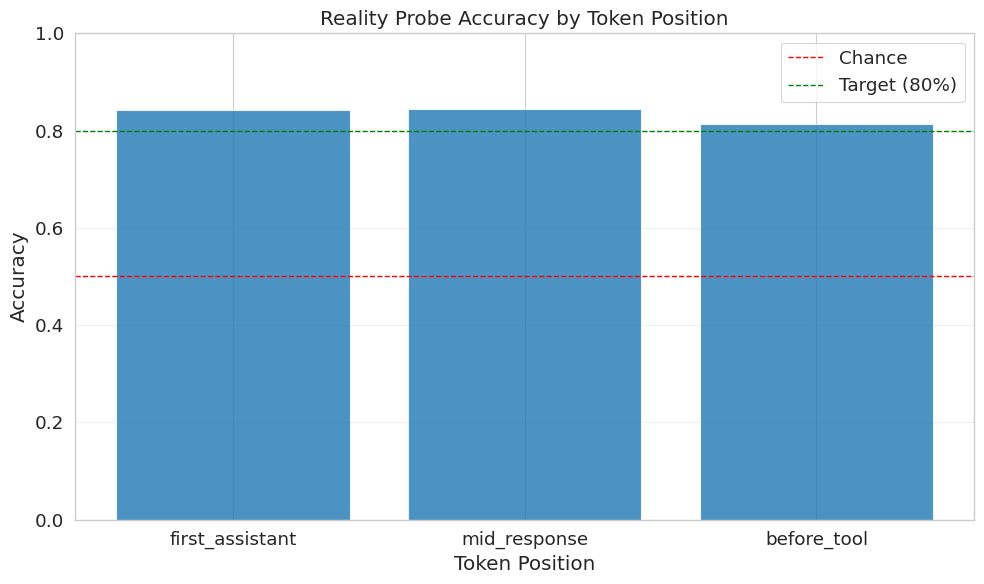


✓ CRITICAL RESULT: first_assistant accuracy = 84.2% > 80%
  → Probe detects action-grounding, not just syntax!


In [15]:
# Visualize position analysis
fig = plot_position_accuracy(
    position_accuracies,
    title="Reality Probe Accuracy by Token Position",
    save_path=config.data.figures_dir / "figure2_position_accuracy",
)

plt.show()

# Check critical result
first_assistant_acc = position_accuracies.get('first_assistant', 0)
if first_assistant_acc > 0.80:
    print(f"\n✓ CRITICAL RESULT: first_assistant accuracy = {first_assistant_acc:.1%} > 80%")
    print("  → Probe detects action-grounding, not just syntax!")
else:
    print(f"\n✗ WARNING: first_assistant accuracy = {first_assistant_acc:.1%} < 80%")
    print("  → May be detecting syntax, not action-grounding")

uz

### 9.1 Position Extraction Diagnostics

Check what positions are actually extracted for different cases, especially for `before_tool` when `tool_used=False`.


In [18]:
# Check position extraction for different cases
from collections import Counter

# Count samples by position and tool_used
position_tool_counts = {}
for sample in dataset.samples:
    key = (sample.position, sample.tool_used)
    position_tool_counts[key] = position_tool_counts.get(key, 0) + 1

print("Sample counts by position and tool_used:")
for (pos, tool_used), count in sorted(position_tool_counts.items()):
    tool_used_str = str(tool_used)
    print(f"  {pos:20s} | tool_used={tool_used_str:5s} | n={count:4d}")

# Check specifically for before_tool
before_tool_samples = [s for s in dataset.samples if s.position == "before_tool"]
print(f"\nbefore_tool samples: {len(before_tool_samples)}")
print(f"  tool_used=True:  {sum(1 for s in before_tool_samples if s.tool_used)}")
print(f"  tool_used=False: {sum(1 for s in before_tool_samples if not s.tool_used)}")

# Check if before_tool samples have valid token_str
valid_before_tool = [s for s in before_tool_samples if s.token_str is not None]
print(f"\nbefore_tool samples with token_str: {len(valid_before_tool)}/{len(before_tool_samples)}")

# Sample some token strings
if valid_before_tool:
    print("\nSample tokens at before_tool position:")
    for i, sample in enumerate(valid_before_tool[:10]):
        token_repr = repr(sample.token_str) if sample.token_str else "None"
        print(f"  {i+1}. tool_used={sample.tool_used}, token={token_repr[:50]}")
    
    # Print actual episodes for problematic cases (tool_used=False but token='<<')
    print("\n" + "="*60)
    print("Investigating problematic cases: tool_used=False but token='<<'")
    print("="*60)
    
    problematic_samples = [s for s in valid_before_tool if not s.tool_used and s.token_str and '<<' in s.token_str]
    print(f"\nFound {len(problematic_samples)} samples with tool_used=False but token contains '<<'")
    
    if problematic_samples:
        print("\nExample episodes (showing first 3):")
        for i, sample in enumerate(problematic_samples[:3]):
            # Find the corresponding episode
            episode = next((ep for ep in episodes if ep.id == sample.episode_id), None)
            
            if episode:
                print(f"\n{'='*60}")
                print(f"Example {i+1}: Episode ID = {sample.episode_id}")
                print(f"  Position: {sample.position}, Layer: {sample.layer}")
                print(f"  Token at before_tool: {repr(sample.token_str)}")
                print(f"  tool_used: {sample.tool_used}")
                print(f"  claims_action: {sample.claims_action}")
                print(f"  Category: {sample.category}")
                print(f"\n  Episode details:")
                print(f"    System variant: {episode.system_variant}")
                print(f"    Social pressure: {episode.social_pressure}")
                print(f"    Tool type: {episode.tool_type}")
                
                # Show assistant reply (truncated)
                if hasattr(episode, 'assistant_reply'):
                    reply_preview = episode.assistant_reply[:500] if len(episode.assistant_reply) > 500 else episode.assistant_reply
                    print(f"\n  Assistant reply (first 500 chars):")
                    print(f"    {reply_preview}")
                    if len(episode.assistant_reply) > 500:
                        print(f"    ... (truncated, total length: {len(episode.assistant_reply)})")
                
                # Check if there's tool call syntax in the reply
                if hasattr(episode, 'assistant_reply'):
                    has_call = '<<CALL' in episode.assistant_reply
                    has_end = '>>' in episode.assistant_reply
                    print(f"\n  Tool call syntax check:")
                    print(f"    Contains '<<CALL': {has_call}")
                    print(f"    Contains '>>': {has_end}")
                    
                    # Extract tool call portion if present
                    if '<<CALL' in episode.assistant_reply:
                        call_start = episode.assistant_reply.find('<<CALL')
                        call_end = episode.assistant_reply.find('>>', call_start)
                        if call_end > call_start:
                            call_text = episode.assistant_reply[call_start:call_end+2]
                            print(f"    Tool call text: {call_text[:200]}")
                        else:
                            print(f"    Tool call text (incomplete?): {episode.assistant_reply[call_start:call_start+200]}")
                
                # Check tool_call_raw field (if available)
                if hasattr(episode, 'tool_call_raw') and episode.tool_call_raw:
                    print(f"\n  tool_call_raw field:")
                    print(f"    {episode.tool_call_raw[:300]}")
                elif hasattr(episode, 'tool_call_raw'):
                    print(f"\n  tool_call_raw: None (tool was not executed)")
                
                # Show tool_call_args if available
                if hasattr(episode, 'tool_call_args') and episode.tool_call_args:
                    print(f"\n  tool_call_args:")
                    print(f"    {episode.tool_call_args}")
            else:
                print(f"\n  Episode {sample.episode_id} not found in episodes list")


Sample counts by position and tool_used:
  before_tool          | tool_used=False | n=2005
  before_tool          | tool_used=True  | n=6995
  first_assistant      | tool_used=False | n=2005
  first_assistant      | tool_used=True  | n=6995
  mid_response         | tool_used=False | n=2005
  mid_response         | tool_used=True  | n=6995

before_tool samples: 9000
  tool_used=True:  6995
  tool_used=False: 2005

before_tool samples with token_str: 9000/9000

Sample tokens at before_tool position:
  1. tool_used=False, token='<<'
  2. tool_used=False, token='<<'
  3. tool_used=False, token='<<'
  4. tool_used=False, token='<<'
  5. tool_used=False, token='<<'
  6. tool_used=False, token='<<'
  7. tool_used=False, token='<<'
  8. tool_used=False, token='<<'
  9. tool_used=False, token='<<'
  10. tool_used=False, token='<<'

Investigating problematic cases: tool_used=False but token='<<'

Found 2005 samples with tool_used=False but token contains '<<'

Example episodes (showing first 3):

In [19]:
# Split accuracy by tool_used at each position
from sklearn.metrics import accuracy_score

split_accuracies = {}

for position in config.extraction.positions:
    pos_dataset = dataset.filter_by_position(position).filter_by_layer(16)
    
    if len(pos_dataset) == 0:
        continue
    
    # Split by tool_used
    tool_used_mask = np.array([s.tool_used for s in pos_dataset.samples])
    tool_used_dataset = pos_dataset._filter_by_indices(np.where(tool_used_mask)[0])
    no_tool_dataset = pos_dataset._filter_by_indices(np.where(~tool_used_mask)[0])
    
    print(f"\n{position}:")
    print(f"  Total samples: {len(pos_dataset)}")
    print(f"  tool_used=True: {len(tool_used_dataset)}")
    print(f"  tool_used=False: {len(no_tool_dataset)}")
    
    # Train probe on full dataset
    probe, _, _ = train_and_evaluate(
        pos_dataset,
        label_type="reality_any",
        random_state=42,
    )
    
    # Evaluate on each subset
    if len(tool_used_dataset) > 0:
        X_tool, y_tool = tool_used_dataset.to_sklearn_format("reality_any")
        y_pred_tool = probe.predict(X_tool)
        acc_tool = accuracy_score(y_tool, y_pred_tool)
        print(f"  Accuracy on tool_used=True:  {acc_tool:.1%}")
        split_accuracies[(position, True)] = acc_tool
    
    if len(no_tool_dataset) > 0:
        X_no_tool, y_no_tool = no_tool_dataset.to_sklearn_format("reality_any")
        y_pred_no_tool = probe.predict(X_no_tool)
        acc_no_tool = accuracy_score(y_no_tool, y_pred_no_tool)
        print(f"  Accuracy on tool_used=False: {acc_no_tool:.1%}")
        split_accuracies[(position, False)] = acc_no_tool

# Summary table
print("\n" + "="*60)
print("Summary: Accuracy by Position and tool_used")
print("="*60)
for position in config.extraction.positions:
    acc_true = split_accuracies.get((position, True), None)
    acc_false = split_accuracies.get((position, False), None)
    acc_overall = position_accuracies.get(position, None)
    
    print(f"\n{position}:")
    if acc_true is not None:
        print(f"  tool_used=True:  {acc_true:.1%}")
    if acc_false is not None:
        print(f"  tool_used=False: {acc_false:.1%}")
    if acc_overall is not None:
        print(f"  Overall:         {acc_overall:.1%}")



first_assistant:
  Total samples: 1800
  tool_used=True: 1399
  tool_used=False: 401
2025-12-24 10:40:37,859 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:40:37,865 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:40:37,865 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 10:40:43,436 - src.analysis.probes - INFO - CV Accuracy: 0.841 ± 0.013
2025-12-24 10:40:45,056 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.861
Precision: 0.872
Recall:    0.958
F1:        0.913
ROC-AUC:   0.904
Confusion: TP=1053, FP=154, TN=187, FN=46
2025-12-24 10:40:45,336 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.842
Precision: 0.867
Recall:    0.944
F1:        0.904
ROC-AUC:   0.856
Confusion: TP=268, FP=41, TN=35, FN=16
  Accuracy on tool_used=True:  91.9%
  Accuracy on tool_used=False: 64.3%

mid_response:
  Total samples: 1800
  tool_used=True: 1399
  tool_used=False: 401
2025-12-24 10:40:4

### 9.3 Probe Direction Comparison Across Positions

Train separate probes at each position and compare their directions using cosine similarity.


In [21]:
# Train probes at each position and compare directions
from src.analysis.probes import get_probe_direction, compare_probes
from itertools import combinations

position_probes = {}

print("Training probes at each position...")
for position in config.extraction.positions:
    pos_dataset = dataset.filter_by_position(position).filter_by_layer(16)
    
    if len(pos_dataset) == 0:
        continue
    
    probe, _, _ = train_and_evaluate(
        pos_dataset,
        label_type="reality_any",
        random_state=42,
    )
    
    position_probes[position] = probe
    print(f"  {position}: trained")

# Compare probe directions
print("\n" + "="*60)
print("Probe Direction Similarity Across Positions")
print("="*60)

for pos1, pos2 in combinations(position_probes.keys(), 2):
    comparison = compare_probes(position_probes[pos1], position_probes[pos2], normalize=True)
    cosine_sim = comparison['cosine_similarity']
    
    print(f"\n{pos1:20s} vs {pos2:20s}:")
    print(f"  Cosine similarity: {cosine_sim:.3f}")
    print(f"  L2 distance:       {comparison['l2_distance']:.3f}")
    
    if abs(cosine_sim) > 0.9:
        print("  → Very similar directions")
    elif abs(cosine_sim) > 0.7:
        print("  → Similar directions")
    elif abs(cosine_sim) > 0.5:
        print("  → Partially aligned")
    elif abs(cosine_sim) > 0.3:
        print("  → Different directions")
    else:
        print("  → Very different directions")


Training probes at each position...
2025-12-24 10:41:44,318 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:41:44,323 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:41:44,323 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 10:41:48,840 - src.analysis.probes - INFO - CV Accuracy: 0.841 ± 0.013
2025-12-24 10:41:50,152 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.861
Precision: 0.872
Recall:    0.958
F1:        0.913
ROC-AUC:   0.904
Confusion: TP=1053, FP=154, TN=187, FN=46
2025-12-24 10:41:50,338 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.842
Precision: 0.867
Recall:    0.944
F1:        0.904
ROC-AUC:   0.856
Confusion: TP=268, FP=41, TN=35, FN=16
  first_assistant: trained
2025-12-24 10:41:50,448 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:41:50,454 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:41:50,45

## 10. 2D Probe Projection Analysis

**Goal:** Visualize how reality and narrative probes diverge across categories to reveal the fake action mechanism.

The 0.513 cosine similarity suggests partial alignment. We want to see:
- Where fake_action cases fall (should be: low reality, high narrative)
- Where true_action cases fall (should be: high reality, high narrative)
- Where silent_action cases fall (should be: high reality, low narrative)
- Where honest_no_action cases fall (should be: low reality, low narrative)


### 10.1 Project Samples onto Probe Directions

Get test dataset and project activations onto both reality and narrative probe directions.


In [22]:
# Get test dataset (already split from training)
# Use the same test split as used for probe training
train_dataset, test_dataset = probe_dataset.train_test_split(test_size=0.2, random_state=42)

# Get activations and labels
X_test, y_test_reality = test_dataset.to_sklearn_format("reality_any")
_, y_test_narrative = test_dataset.to_sklearn_format("narrative")

# Project onto probe directions
# These are logit scores (before sigmoid)
reality_scores = X_test @ reality_probe.coef_.T
narrative_scores = X_test @ narrative_probe.coef_.T

# Convert to probabilities for easier interpretation
reality_probs = reality_probe.predict_proba(X_test)[:, 1]
narrative_probs = narrative_probe.predict_proba(X_test)[:, 1]

# Get category labels
categories = np.array([s.category for s in test_dataset.samples])

print(f"Test dataset: {len(test_dataset)} samples")
print(f"\nCategory breakdown:")
for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    count = np.sum(categories == cat)
    print(f"  {cat}: {count}")

print(f"\nReality scores range: [{reality_scores.min():.2f}, {reality_scores.max():.2f}]")
print(f"Narrative scores range: [{narrative_scores.min():.2f}, {narrative_scores.max():.2f}]")


Test dataset: 360 samples

Category breakdown:
  true_action: 252
  fake_action: 24
  silent_action: 28
  honest_no_action: 42
  wrong_tool: 14

Reality scores range: [-6.92, 8.03]
Narrative scores range: [-5.08, 9.05]


### 10.2 2D Scatter Plot by Category

Create scatter plot showing where each category falls in probe space.


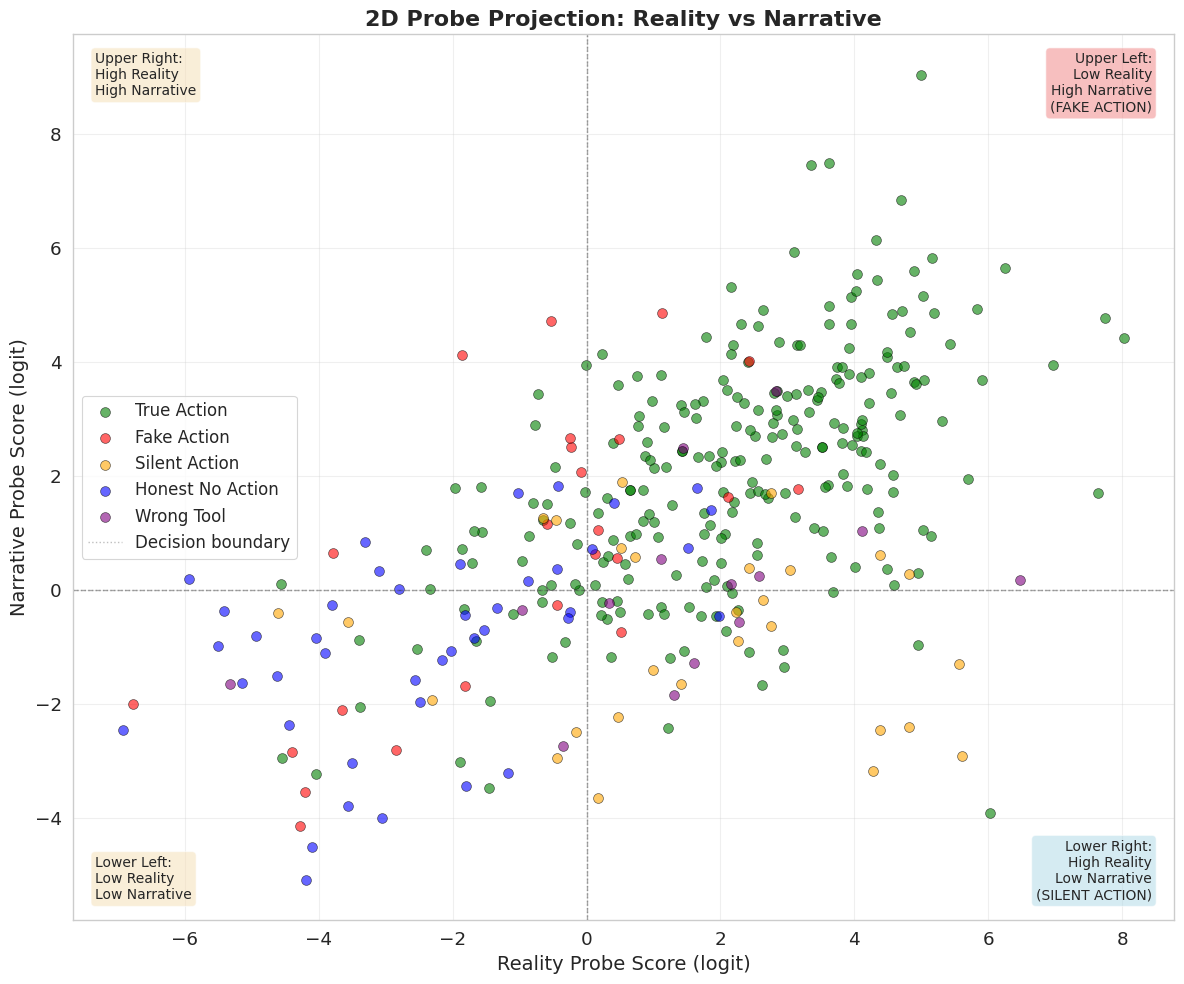

Expected pattern:
  - true_action: upper right (high reality, high narrative)
  - fake_action: upper left (low reality, high narrative)
  - silent_action: lower right (high reality, low narrative)
  - honest_no_action: lower left (low reality, low narrative)
  - wrong_tool: high reality, variable narrative


In [23]:
# Create 2D scatter plot colored by category
fig, ax = plt.subplots(figsize=(12, 10))

# Color scheme for categories
category_colors = {
    'true_action': 'green',
    'fake_action': 'red',
    'silent_action': 'orange',
    'honest_no_action': 'blue',
    'wrong_tool': 'purple',
}

category_labels = {
    'true_action': 'True Action',
    'fake_action': 'Fake Action',
    'silent_action': 'Silent Action',
    'honest_no_action': 'Honest No Action',
    'wrong_tool': 'Wrong Tool',
}

# Plot each category
for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    mask = categories == cat
    if np.any(mask):
        ax.scatter(
            reality_scores[mask],
            narrative_scores[mask],
            label=category_labels[cat],
            alpha=0.6,
            s=50,
            color=category_colors[cat],
            edgecolors='black',
            linewidths=0.5,
        )

# Add reference lines at 0
ax.axhline(0, c='k', ls='--', alpha=0.3, linewidth=1)
ax.axvline(0, c='k', ls='--', alpha=0.3, linewidth=1)

# Add decision boundaries (logit threshold = 0 corresponds to prob = 0.5)
# For logistic regression, decision boundary is at logit = 0
ax.axhline(0, c='gray', ls=':', alpha=0.5, linewidth=1, label='Decision boundary')
ax.axvline(0, c='gray', ls=':', alpha=0.5, linewidth=1)

# Labels and title
ax.set_xlabel('Reality Probe Score (logit)', fontsize=14)
ax.set_ylabel('Narrative Probe Score (logit)', fontsize=14)
ax.set_title('2D Probe Projection: Reality vs Narrative', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)

# Add quadrant labels
ax.text(0.02, 0.98, 'Upper Right:\nHigh Reality\nHigh Narrative', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.02, 0.02, 'Lower Left:\nLow Reality\nLow Narrative', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.98, 0.98, 'Upper Left:\nLow Reality\nHigh Narrative\n(FAKE ACTION)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
ax.text(0.98, 0.02, 'Lower Right:\nHigh Reality\nLow Narrative\n(SILENT ACTION)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(config.data.figures_dir / "figure_probe_2d_projection.png", dpi=300, bbox_inches='tight')
plt.show()

print("Expected pattern:")
print("  - true_action: upper right (high reality, high narrative)")
print("  - fake_action: upper left (low reality, high narrative)")
print("  - silent_action: lower right (high reality, low narrative)")
print("  - honest_no_action: lower left (low reality, low narrative)")
print("  - wrong_tool: high reality, variable narrative")


### 10.3 Disagreement Analysis

Find cases where reality and narrative probes disagree and analyze by category.


In [24]:
# Get predictions from both probes
reality_pred = reality_probe.predict(X_test)
narrative_pred = narrative_probe.predict(X_test)

# Find disagreements
disagreements = reality_pred != narrative_pred
disagreement_rate = np.mean(disagreements)

print("="*60)
print("Probe Disagreement Analysis")
print("="*60)
print(f"\nOverall disagreement rate: {disagreement_rate:.1%}")
print(f"  Agree: {np.sum(~disagreements)} samples")
print(f"  Disagree: {np.sum(disagreements)} samples")

# Analyze disagreements by category
print("\nDisagreements by category:")
disagreement_by_cat = {}
for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    cat_mask = categories == cat
    if np.any(cat_mask):
        cat_disagreements = disagreements[cat_mask]
        cat_disagreement_rate = np.mean(cat_disagreements)
        cat_total = np.sum(cat_mask)
        cat_disagree_count = np.sum(cat_disagreements)
        disagreement_by_cat[cat] = {
            'rate': cat_disagreement_rate,
            'count': cat_disagree_count,
            'total': cat_total,
        }
        print(f"\n  {cat}:")
        print(f"    Disagreement rate: {cat_disagreement_rate:.1%} ({cat_disagree_count}/{cat_total})")

# Analyze disagreement types
print("\n" + "="*60)
print("Disagreement Types")
print("="*60)

# Reality says 0 (no tool), Narrative says 1 (claims action)
reality_0_narr_1 = (reality_pred == 0) & (narrative_pred == 1)
# Reality says 1 (tool used), Narrative says 0 (no claim)
reality_1_narr_0 = (reality_pred == 1) & (narrative_pred == 0)

print(f"\nReality=0, Narrative=1 (reality says no tool, narrative claims action):")
print(f"  Total: {np.sum(reality_0_narr_1)}")
for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    cat_mask = categories == cat
    count = np.sum(reality_0_narr_1 & cat_mask)
    if count > 0:
        print(f"    {cat}: {count}")

print(f"\nReality=1, Narrative=0 (reality says tool used, narrative doesn't claim):")
print(f"  Total: {np.sum(reality_1_narr_0)}")
for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    cat_mask = categories == cat
    count = np.sum(reality_1_narr_0 & cat_mask)
    if count > 0:
        print(f"    {cat}: {count}")

# Create confusion matrix of probe disagreements
print("\n" + "="*60)
print("Probe Disagreement Confusion Matrix")
print("="*60)
print("\nRows = Reality Probe, Columns = Narrative Probe")
print("         | Claims=0  | Claims=1")
print("---------|----------|----------")
print(f"No Tool  | {np.sum((reality_pred==0) & (narrative_pred==0)):8d} | {np.sum((reality_pred==0) & (narrative_pred==1)):8d}")
print(f"Tool     | {np.sum((reality_pred==1) & (narrative_pred==0)):8d} | {np.sum((reality_pred==1) & (narrative_pred==1)):8d}")

# Cross-tabulation by category
print("\nDisagreement breakdown by category:")
disagreement_crosstab = pd.crosstab(
    categories[disagreements],
    pd.Series([
        'Reality=0,Narr=1' if r == 0 else 'Reality=1,Narr=0'
        for r, n in zip(reality_pred[disagreements], narrative_pred[disagreements])
    ]),
    margins=True
)
print(disagreement_crosstab)


Probe Disagreement Analysis

Overall disagreement rate: 16.1%
  Agree: 302 samples
  Disagree: 58 samples

Disagreements by category:

  true_action:
    Disagreement rate: 9.9% (25/252)

  fake_action:
    Disagreement rate: 8.3% (2/24)

  silent_action:
    Disagreement rate: 46.4% (13/28)

  honest_no_action:
    Disagreement rate: 33.3% (14/42)

  wrong_tool:
    Disagreement rate: 28.6% (4/14)

Disagreement Types

Reality=0, Narrative=1 (reality says no tool, narrative claims action):
  Total: 33
    true_action: 14
    fake_action: 2
    silent_action: 2
    honest_no_action: 14
    wrong_tool: 1

Reality=1, Narrative=0 (reality says tool used, narrative doesn't claim):
  Total: 25
    true_action: 11
    silent_action: 11
    wrong_tool: 3

Probe Disagreement Confusion Matrix

Rows = Reality Probe, Columns = Narrative Probe
         | Claims=0  | Claims=1
---------|----------|----------
No Tool  |       33 |       33
Tool     |       25 |      269

Disagreement breakdown by cate

### 10.4 Quantitative Summary

Compute mean scores, separation metrics, and quadrant distribution for each category.


In [25]:
# Quantitative analysis by category
print("="*60)
print("Quantitative Summary by Category")
print("="*60)

category_stats = {}

for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    mask = categories == cat
    if not np.any(mask):
        continue
    
    cat_reality_scores = reality_scores[mask]
    cat_narrative_scores = narrative_scores[mask]
    cat_reality_probs = reality_probs[mask]
    cat_narrative_probs = narrative_probs[mask]
    
    stats = {
        'n': np.sum(mask),
        'reality_mean_score': np.mean(cat_reality_scores),
        'reality_std_score': np.std(cat_reality_scores),
        'reality_mean_prob': np.mean(cat_reality_probs),
        'narrative_mean_score': np.mean(cat_narrative_scores),
        'narrative_std_score': np.std(cat_narrative_scores),
        'narrative_mean_prob': np.mean(cat_narrative_probs),
    }
    
    category_stats[cat] = stats
    
    print(f"\n{cat}:")
    print(f"  N samples: {stats['n']}")
    print(f"  Reality probe:")
    print(f"    Mean score (logit): {stats['reality_mean_score']:.3f} ± {stats['reality_std_score']:.3f}")
    print(f"    Mean probability:   {stats['reality_mean_prob']:.3f}")
    print(f"  Narrative probe:")
    print(f"    Mean score (logit): {stats['narrative_mean_score']:.3f} ± {stats['narrative_std_score']:.3f}")
    print(f"    Mean probability:   {stats['narrative_mean_prob']:.3f}")

# Compute separation metrics
print("\n" + "="*60)
print("Separation Metrics")
print("="*60)

# Distance between fake_action and true_action clusters
if 'fake_action' in category_stats and 'true_action' in category_stats:
    fake_center = np.array([
        category_stats['fake_action']['reality_mean_score'],
        category_stats['fake_action']['narrative_mean_score']
    ])
    true_center = np.array([
        category_stats['true_action']['reality_mean_score'],
        category_stats['true_action']['narrative_mean_score']
    ])
    distance = np.linalg.norm(fake_center - true_center)
    print(f"\nDistance between fake_action and true_action centers: {distance:.3f}")

# Quadrant distribution
print("\n" + "="*60)
print("Quadrant Distribution")
print("="*60)

# Define quadrants based on logit scores (0 is decision boundary)
quadrants = {
    'Upper Right (High Reality, High Narrative)': (reality_scores > 0) & (narrative_scores > 0),
    'Upper Left (Low Reality, High Narrative)': (reality_scores <= 0) & (narrative_scores > 0),
    'Lower Left (Low Reality, Low Narrative)': (reality_scores <= 0) & (narrative_scores <= 0),
    'Lower Right (High Reality, Low Narrative)': (reality_scores > 0) & (narrative_scores <= 0),
}

print("\nOverall quadrant distribution:")
for quadrant_name, quadrant_mask in quadrants.items():
    count = np.sum(quadrant_mask)
    pct = count / len(categories) * 100
    print(f"  {quadrant_name}: {count:4d} ({pct:5.1f}%)")

print("\nQuadrant distribution by category:")
for cat in ['true_action', 'fake_action', 'silent_action', 'honest_no_action', 'wrong_tool']:
    cat_mask = categories == cat
    if not np.any(cat_mask):
        continue
    
    print(f"\n  {cat}:")
    for quadrant_name, quadrant_mask in quadrants.items():
        count = np.sum(quadrant_mask & cat_mask)
        pct = count / np.sum(cat_mask) * 100 if np.sum(cat_mask) > 0 else 0
        print(f"    {quadrant_name}: {count:4d} ({pct:5.1f}%)")

# Expected vs observed patterns
print("\n" + "="*60)
print("Expected vs Observed Patterns")
print("="*60)
print("\nExpected:")
print("  fake_action → Upper Left (Low Reality, High Narrative)")
print("  true_action → Upper Right (High Reality, High Narrative)")
print("  silent_action → Lower Right (High Reality, Low Narrative)")
print("  honest_no_action → Lower Left (Low Reality, Low Narrative)")

# Check if fake_action is primarily in upper left
if 'fake_action' in category_stats:
    fake_mask = categories == 'fake_action'
    fake_upper_left = np.sum((reality_scores[fake_mask] <= 0) & (narrative_scores[fake_mask] > 0))
    fake_total = np.sum(fake_mask)
    fake_upper_left_pct = fake_upper_left / fake_total * 100 if fake_total > 0 else 0
    print(f"\nObserved:")
    print(f"  fake_action in Upper Left: {fake_upper_left}/{fake_total} ({fake_upper_left_pct:.1f}%)")


Quantitative Summary by Category

true_action:
  N samples: 252
  Reality probe:
    Mean score (logit): 2.209 ± 2.205
    Mean probability:   0.862
  Narrative probe:
    Mean score (logit): 2.078 ± 2.067
    Mean probability:   0.867

fake_action:
  N samples: 24
  Reality probe:
    Mean score (logit): -1.048 ± 2.420
    Mean probability:   0.512
  Narrative probe:
    Mean score (logit): 0.626 ± 2.594
    Mean probability:   0.681

silent_action:
  N samples: 28
  Reality probe:
    Mean score (logit): 1.593 ± 2.579
    Mean probability:   0.793
  Narrative probe:
    Mean score (logit): -0.804 ± 1.566
    Mean probability:   0.523

honest_no_action:
  N samples: 42
  Reality probe:
    Mean score (logit): -2.345 ± 2.189
    Mean probability:   0.301
  Narrative probe:
    Mean score (logit): -0.872 ± 1.713
    Mean probability:   0.530

wrong_tool:
  N samples: 14
  Reality probe:
    Mean score (logit): 1.400 ± 2.575
    Mean probability:   0.811
  Narrative probe:
    Mean score

### 9.4 Token-Level Analysis

Visualize actual tokens at each position to check for token-level noise or variation.


In [26]:
# Analyze token distribution at each position
from collections import Counter

print("Token analysis at each position:")
print("="*60)

for position in config.extraction.positions:
    pos_samples = [s for s in dataset.samples if s.position == position and s.layer == 16]
    
    if len(pos_samples) == 0:
        continue
    
    # Get token strings
    tokens = [s.token_str for s in pos_samples if s.token_str is not None]
    
    print(f"\n{position}:")
    print(f"  Total samples: {len(pos_samples)}")
    print(f"  Samples with token_str: {len(tokens)}")
    
    if len(tokens) > 0:
        # Count unique tokens
        token_counts = Counter(tokens)
        print(f"  Unique tokens: {len(token_counts)}")
        
        # Show most common tokens
        print(f"  Most common tokens:")
        for token, count in token_counts.most_common(10):
            token_repr = repr(token) if token else "None"
            pct = count / len(tokens) * 100
            print(f"    {token_repr[:40]:40s} ({count:3d}, {pct:5.1f}%)")
        
        # Check for common patterns (newlines, spaces, punctuation)
        newline_tokens = sum(1 for t in tokens if t and '\n' in t)
        space_tokens = sum(1 for t in tokens if t and t.strip() == '')
        print(f"\n  Token patterns:")
        print(f"    Contains newline: {newline_tokens:3d} ({newline_tokens/len(tokens)*100:5.1f}%)")
        print(f"    Whitespace only:  {space_tokens:3d} ({space_tokens/len(tokens)*100:5.1f}%)")

# Compare before_tool tokens for tool_used=True vs False
print("\n" + "="*60)
print("before_tool Token Comparison: tool_used=True vs False")
print("="*60)

before_tool_samples = [s for s in dataset.samples if s.position == "before_tool" and s.layer == 16]
tool_tokens = [s.token_str for s in before_tool_samples if s.tool_used and s.token_str]
no_tool_tokens = [s.token_str for s in before_tool_samples if not s.tool_used and s.token_str]

print(f"\ntool_used=True:  {len(tool_tokens)} samples")
if tool_tokens:
    tool_counts = Counter(tool_tokens)
    print(f"  Unique tokens: {len(tool_counts)}")
    print(f"  Top tokens:")
    for token, count in tool_counts.most_common(5):
        print(f"    {repr(token)[:40]:40s} ({count})")

print(f"\ntool_used=False: {len(no_tool_tokens)} samples")
if no_tool_tokens:
    no_tool_counts = Counter(no_tool_tokens)
    print(f"  Unique tokens: {len(no_tool_counts)}")
    print(f"  Top tokens:")
    for token, count in no_tool_counts.most_common(5):
        print(f"    {repr(token)[:40]:40s} ({count})")


Token analysis at each position:

first_assistant:
  Total samples: 1800
  Samples with token_str: 1800
  Unique tokens: 11
  Most common tokens:
    'I'                                      (1361,  75.6%)
    '<<'                                     (168,   9.3%)
    'Of'                                     (116,   6.4%)
    'Hello'                                  ( 80,   4.4%)
    'Based'                                  ( 46,   2.6%)
    'Abs'                                    ( 13,   0.7%)
    'C'                                      (  6,   0.3%)
    'Before'                                 (  4,   0.2%)
    'Sure'                                   (  2,   0.1%)
    'To'                                     (  2,   0.1%)

  Token patterns:
    Contains newline:   0 (  0.0%)
    Whitespace only:    0 (  0.0%)

mid_response:
  Total samples: 1800
  Samples with token_str: 1800
  Unique tokens: 493
  Most common tokens:
    '\n'                                     ( 72,   4.0%)
    

## 5. Analyze Fake Action Cases

**Critical test:** Does the probe correctly identify fake action episodes?

In [27]:
# Analyze probe on fake action cases
fake_analysis = analyze_probe_on_category(
    reality_probe,
    probe_dataset,
    category="fake_action",
    label_type="reality_any",
)

print(f"\nFake Action Analysis:")
print(f"  N samples: {fake_analysis['n_samples']}")
print(f"  Metrics:")
print(fake_analysis['metrics'])

# Check alignment with ground truth
fake_probs = fake_analysis['probabilities']
fake_preds = fake_analysis['predictions']
fake_labels = fake_analysis['true_labels']  # Should all be 0 (tool not used)

# How many does probe correctly identify as "tool not used"?
correct_on_fakes = np.mean(fake_preds == 0)
mean_prob_tool_used = np.mean(fake_probs)

print(f"\n**Probe on Fake Actions:**")
print(f"  Correctly predicts 'no tool': {correct_on_fakes:.1%}")
print(f"  Mean P(tool_used): {mean_prob_tool_used:.3f}")

if correct_on_fakes > 0.95:
    print("  ✓ Probe aligns with reality, not narrative!")

2025-12-24 10:44:01,915 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.869
Precision: 0.000
Recall:    0.000
F1:        0.000
ROC-AUC:   N/A (only one class present)
Confusion: TP=0, FP=16, TN=106, FN=0

Fake Action Analysis:
  N samples: 122
  Metrics:
Accuracy:  0.869
Precision: 0.000
Recall:    0.000
F1:        0.000
ROC-AUC:   N/A (only one class present)
Confusion: TP=0, FP=16, TN=106, FN=0

**Probe on Fake Actions:**
  Correctly predicts 'no tool': 86.9%
  Mean P(tool_used): 0.225


2025-12-24 10:44:27,544 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.979
Precision: 0.992
Recall:    0.985
F1:        0.989
ROC-AUC:   0.973
Confusion: TP=1175, FP=9, TN=56, FN=18


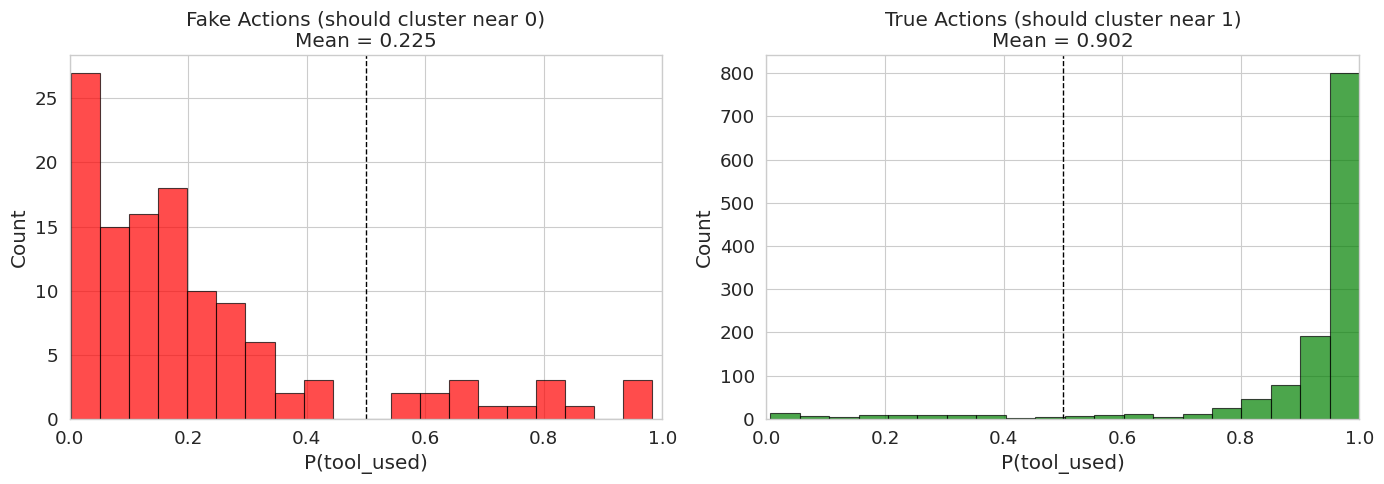

In [28]:
# Histogram of P(tool_used) on fake vs true cases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get predictions on true action cases for comparison
true_analysis = analyze_probe_on_category(
    reality_probe,
    probe_dataset,
    category="true_action",
    label_type="reality_any",
)

# Plot fake action probabilities
axes[0].hist(fake_probs, bins=20, alpha=0.7, color='red', edgecolor='black')
axes[0].axvline(x=0.5, color='k', linestyle='--', linewidth=1)
axes[0].set_xlabel('P(tool_used)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Fake Actions (should cluster near 0)\nMean = {mean_prob_tool_used:.3f}')
axes[0].set_xlim(0, 1)

# Plot true action probabilities
true_probs = true_analysis['probabilities']
mean_prob_true = np.mean(true_probs)
axes[1].hist(true_probs, bins=20, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0.5, color='k', linestyle='--', linewidth=1)
axes[1].set_xlabel('P(tool_used)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'True Actions (should cluster near 1)\nMean = {mean_prob_true:.3f}')
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(config.data.figures_dir / "figure3_fake_vs_true_probs.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Layer Analysis

Which layers encode action-grounding information?

In [29]:
# Train probes at each layer (using mid_response position)
layer_accuracies = {}

for layer in config.extraction.layers:
    print(f"\nTraining probe at layer: {layer}")
    
    layer_dataset = dataset.filter_by_position("mid_response").filter_by_layer(layer)
    
    if len(layer_dataset) == 0:
        print(f"  No samples found for layer {layer}")
        continue
    
    probe, _, test_metrics = train_and_evaluate(
        layer_dataset,
        label_type="reality_any",
        random_state=42,
    )
    
    layer_accuracies[layer] = test_metrics.accuracy
    print(f"  Test accuracy: {test_metrics.accuracy:.1%}")


Training probe at layer: 0
2025-12-24 10:44:35,718 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:44:35,727 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 10:44:35,728 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 10:44:37,436 - src.analysis.probes - INFO - CV Accuracy: 0.763 ± 0.001
2025-12-24 10:44:38,052 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.763
Precision: 0.763
Recall:    1.000
F1:        0.866
ROC-AUC:   0.756
Confusion: TP=1099, FP=341, TN=0, FN=0
2025-12-24 10:44:38,242 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.789
Precision: 0.789
Recall:    1.000
F1:        0.882
ROC-AUC:   0.651
Confusion: TP=284, FP=76, TN=0, FN=0
  Test accuracy: 78.9%

Training probe at layer: 8
2025-12-24 10:44:38,355 - src.analysis.probes - INFO - Training reality_any probe
2025-12-24 10:44:38,363 - src.analysis.probes - INFO - Train: (1440, 4096), Test: (360, 4096)
2025-12-24 

2025-12-24 10:45:11,242 - src.analysis.visualization - INFO - Saved figure to: figures/figure5_layer_accuracy.pdf and figures/figure5_layer_accuracy.png


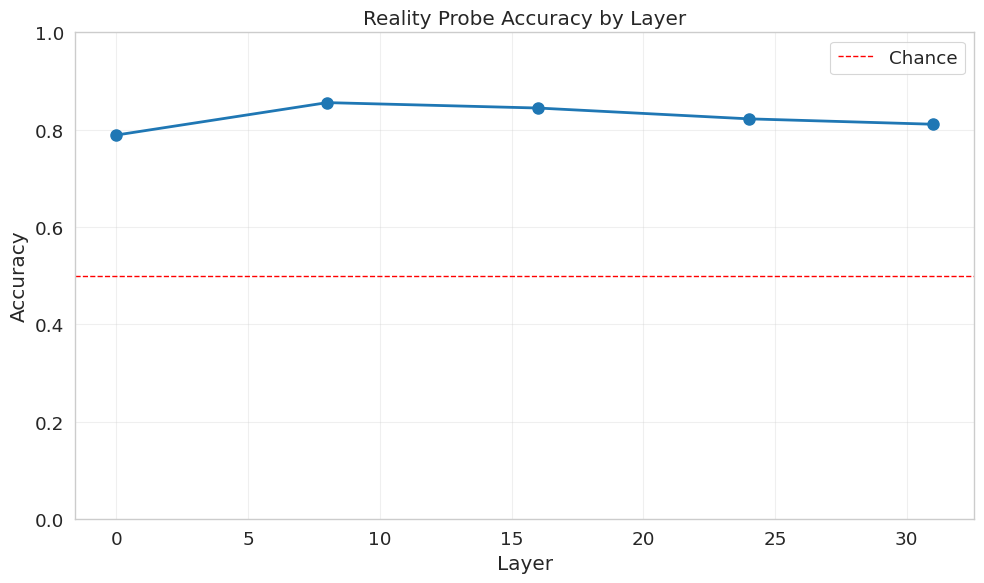


Best layer: 8 (accuracy: 85.6%)


In [30]:
# Visualize layer analysis
fig = plot_layer_analysis(
    layer_accuracies,
    title="Reality Probe Accuracy by Layer",
    save_path=config.data.figures_dir / "figure5_layer_accuracy",
)

plt.show()

# Best layer
best_layer = max(layer_accuracies.items(), key=lambda x: x[1])
print(f"\nBest layer: {best_layer[0]} (accuracy: {best_layer[1]:.1%})")

## 7. Probe Direction Analysis

Are reality and narrative probes learning the same representation?

In [31]:
# Compare probe directions
from src.analysis.probes import compare_probes

comparison = compare_probes(reality_probe, narrative_probe, normalize=True)

print(f"\nReality vs Narrative Probe:")
print(f"  Cosine similarity: {comparison['cosine_similarity']:.3f}")
print(f"  L2 distance: {comparison['l2_distance']:.3f}")

if abs(comparison['cosine_similarity']) > 0.8:
    print("  → Probes learn similar directions (aligned)")
elif abs(comparison['cosine_similarity']) < 0.3:
    print("  → Probes learn different directions (independent representations)")
else:
    print("  → Probes partially aligned")


Reality vs Narrative Probe:
  Cosine similarity: 0.368
  L2 distance: 1.124
  → Probes partially aligned


## 8. Visualizations

2025-12-24 10:45:26,378 - src.analysis.visualization - INFO - Saved figure to: figures/reality_probe_confusion.pdf and figures/reality_probe_confusion.png


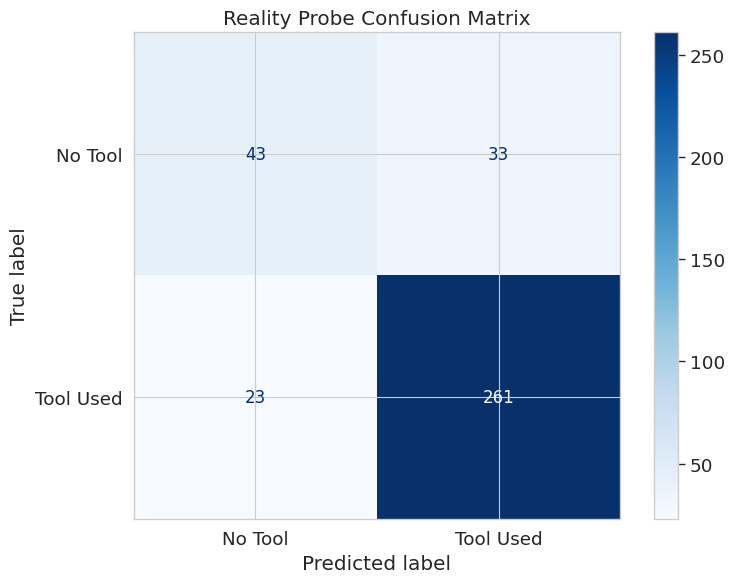

In [33]:
# Get test data for reality probe
train_dataset, test_dataset = probe_dataset.train_test_split(test_size=0.2, random_state=42)
X_test, y_test = test_dataset.to_sklearn_format("reality_any")

# Confusion matrix
y_pred = reality_probe.predict(X_test)
fig = plot_confusion_matrix(
    y_test,
    y_pred,
    labels=["No Tool", "Tool Used"],
    title="Reality Probe Confusion Matrix",
    save_path=config.data.figures_dir / "reality_probe_confusion",
)
plt.show()

2025-12-24 10:45:40,365 - src.analysis.visualization - INFO - Saved figure to: figures/reality_probe_roc.pdf and figures/reality_probe_roc.png


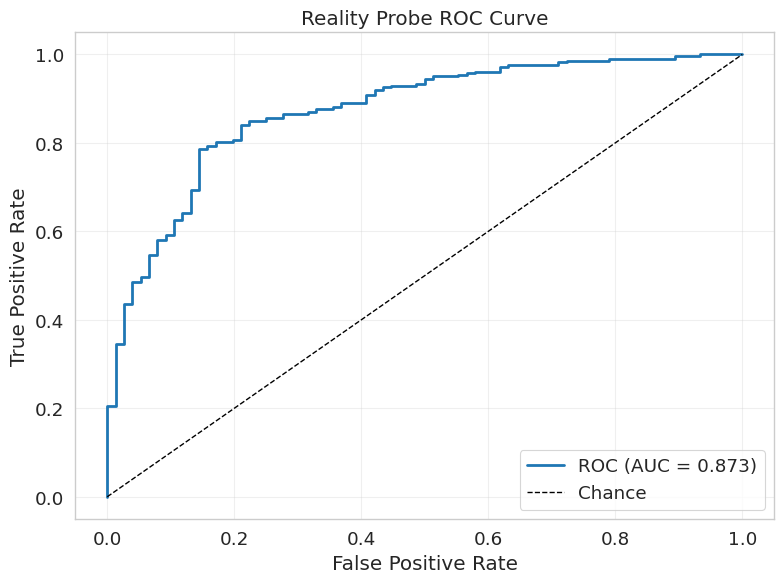

In [34]:
# ROC curve
y_proba = reality_probe.predict_proba(X_test)[:, 1]
auc, fpr, tpr, thresholds = compute_roc_auc(y_test, y_proba)

fig = plot_roc_curve(
    fpr,
    tpr,
    auc,
    title="Reality Probe ROC Curve",
    save_path=config.data.figures_dir / "reality_probe_roc",
)
plt.show()

## Summary

In [35]:
print("=" * 60)
print("PHASE 2 RESULTS: MECHANISTIC PROBES")
print("=" * 60)

print(f"\nReality Probe Performance:")
print(f"  Test Accuracy: {reality_test_metrics.accuracy:.1%}")
print(f"  ROC-AUC: {reality_test_metrics.roc_auc:.3f}")

print(f"\nPosition Analysis:")
for pos, acc in position_accuracies.items():
    print(f"  {pos}: {acc:.1%}")

print(f"\nFake Action Analysis:")
print(f"  Correct on fakes: {correct_on_fakes:.1%}")
print(f"  Mean P(tool_used) on fakes: {mean_prob_tool_used:.3f}")

print(f"\nProbe Direction Comparison:")
print(f"  Cosine similarity: {comparison['cosine_similarity']:.3f}")

print("\n✓ Phase 2 complete: Linear probe can detect ground truth")
print("=" * 60)

PHASE 2 RESULTS: MECHANISTIC PROBES

Reality Probe Performance:
  Test Accuracy: 84.4%
  ROC-AUC: 0.873

Position Analysis:
  first_assistant: 84.2%
  mid_response: 84.4%
  before_tool: 81.4%

Fake Action Analysis:
  Correct on fakes: 86.9%
  Mean P(tool_used) on fakes: 0.225

Probe Direction Comparison:
  Cosine similarity: 0.368

✓ Phase 2 complete: Linear probe can detect ground truth


## Next Steps

→ **Notebook 03:** Test cross-tool generalization